# Simulate the data acquisition of SquareLab

In [2]:
# Importing some packages
import numpy as np
import matplotlib.pyplot as mpl

## A bunch of parameters

In [3]:
time_scale = 0.1 #value in seconds
x_divisions = 10
number_of_samples = 5000

timescales = np.logspace(-7, 2, 10)
timescales = [timescales*a for a in [1, 2, 5]]
timescales = np.sort(np.reshape(timescales, 30))
print(timescales)

horizontal_scale = 0.5
adc_bits = 12
y_division = 10

f_sampling_max = 7.2e6
target_fps = 30

fps = min(1/time_scale, target_fps)

trigger_position = 0.1 #in div

[1.e-07 2.e-07 5.e-07 1.e-06 2.e-06 5.e-06 1.e-05 2.e-05 5.e-05 1.e-04
 2.e-04 5.e-04 1.e-03 2.e-03 5.e-03 1.e-02 2.e-02 5.e-02 1.e-01 2.e-01
 5.e-01 1.e+00 2.e+00 5.e+00 1.e+01 2.e+01 5.e+01 1.e+02 2.e+02 5.e+02]


## Generate test data

In [42]:
# Oversampling to get a smooth curve
oversample = 100
overtime = 3
func_freq = 10

generate_test(np.sin)

NameError: name 'generate_test' is not defined

## Getting measured data

### Quantize the data, acquisition procedure

The maximum time base for real-time sampling is: 0.0001
The actual sample frequency is 5000.0
(2, 5000)


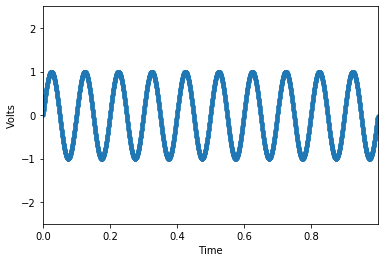

In [78]:
# Deciding if going equivalent time
# Should always get enough data to print in real time

min_timebase_equivalent = number_of_samples/(f_sampling_max*x_divisions)
min_timebase_equivalent = np.argmin(np.where(timescales-min_timebase_equivalent > 0, timescales-min_timebase_equivalent, +np.inf))
min_timebase_equivalent = timescales[min_timebase_equivalent]
print("The maximum time base for real-time sampling is: {}".format(min_timebase_equivalent))

f_sampling = min(f_sampling_max, number_of_samples/(x_divisions*time_scale))
print("The actual sample frequency is {}".format(f_sampling))

# duration of the simulation in seconds
sim_duration = 1

sine_freq = 10

data_acquired = generate_samples(np.sin, f_sampling, sim_duration)
framed_data = data_acquired
framed_data[1] = framed_data[1]*(horizontal_scale*y_division)/pow(2, adc_bits) #normalizing back
framed_data = acquire_data(data_acquired, (0, 0.9))

graph_data(framed_data[0], framed_data[1])

In [77]:
def acquire_data(data, trigger_position): #data np.array 2x:, x_y
    data_buffer = np.zeros((2, number_of_samples)) #max buffer size is the number of samples
    #fill the buffer before triggering, just at startup othrewise might have trigger set to an x without any data before
    data_buffer[:,:] = data[:,0:number_of_samples]
    print(data_buffer.shape)
    data = data[:,number_of_samples:]
    trigger_position_x = max(min(time_scale*x_divisions, trigger_position[0]), 0) #limit the trigger position inside the timewindow
    
    buffer_pointer = 0
    triggered = 0
    triggerable = 1
    frame_period = 1/fps
    
    for i in range(data.shape[1]):
        if data[1][i] >= trigger_position[1] and not triggered and triggerable:
            np.roll(data, int(number_of_samples*trigger_position_x/(time_scale*x_divisions)) - 1, axis = 0) #shift the buffer to match x trigger. Data grandted to be the old one
            buffer_pointer = int(trigger_position_x/(time_scale*x_divisions)) #Stare attenti che ci sia il punto di trigger
            triggered = 1            
        
        data_buffer[buffer_pointer] = data[i]
        
        if buffer_pointer < number_of_samples:
            buffer_pointer += 1
            triggerable = 0
        else:
            buffer_pointer = 0
            break
    return data_buffer
    
    #prepare frame to be dispatched and hold off until next frame
        #n
        

### Simulate the transmission protocol between SquareLab and PC

In [43]:
def generate_samples(numpy_function, f_sampling, sim_duration):
    data = np.zeros((2, int(f_sampling*sim_duration)))

    #always sampling at given frequency based on the timescale

    for i in range(int(f_sampling*sim_duration)):
        # generating sine data to be acquired
        # i is a time instant
        data[0,i] = i/f_sampling
        data[1,i] = np.floor(numpy_function(2*np.pi*sine_freq*i/f_sampling)*pow(2, adc_bits)/(horizontal_scale*y_division))
    return data

In [19]:
def show_test(numpy_funct):
    x_time = np.linspace(0, time_scale*x_divisions*overtime, number_of_samples*oversample)
    func_freq = 1;
    if numpy_funct == np.sin:
        func_freq = 2*np.pi*func_freq
    y_samples = numpy_funct(func_freq*x_time)

    # Plotting the test data to check correctness
    mpl.figure("Broader view")
    mpl.plot(x_time, y_samples)
    mpl.figure("Real view")
    mpl.plot(x_time[0:int(number_of_samples*oversample/overtime)], y_samples[0:int(number_of_samples*oversample/overtime)])
    mpl.xlabel("Time")
    mpl.ylabel("Volts")
    mpl.show()

In [40]:
def graph_data(x_data, y_data): # matrix x,y as rows
    mpl.figure()
    mpl.axis([0, max(x_data), -y_division/2*horizontal_scale, y_division/2*horizontal_scale])
    mpl.plot(x_data, y_data , marker = ".", linestyle = '')
    mpl.xlabel("Time")
    mpl.ylabel("Volts")

    mpl.show()